# Assignment 6:

You have been provided with a pickle file, containing 100 news articles about some company.  Use appropriate topic modeling technique to identify top N most important topics.

- read_pickle(directory+file.pkl')
- Present top N most important topics in these news articles
- Select N to identify relevant topics, but minimize duplication
- Explain how you selected N

## 1. Import pacakges and data

In [26]:
###Loading Packages###
import pandas as pd  # data frame operations  
import numpy as np  # arrays and math functions

import re # regular expressions
import os # Operation System
from datetime import datetime

import nltk as nltk
import nltk.corpus  
from nltk.text import Text
import sys

import time
import math
from pprint import pprint

import matplotlib.pyplot as plt


import nltk as nltk
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import multiprocessing
import string

import warnings
warnings.filterwarnings("ignore")

from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


import string

import spacy

In [15]:
import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore

from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [45]:

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

C:\Users\60357\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-1

print(f'Using {workers} workers')

Using 7 workers


In [31]:
# helper method to record the time
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [7]:
data = pd.read_pickle('webhose_cat.pkl')

In [8]:
# keep only english articles
news_eng = data[data['language']=='english'].reset_index(drop=True)

In [9]:
news_eng

,crawled,language,text,title,url
0,2018-01-30T18:28:45.012+02:00,english,Avery Dennison's (AVY) Q4 results are likely t...,IRobot downgraded to neutral from buy at Sidot...,http://omgili.com/ri/.wHSUbtEfZQRfU.5KUm1RkeXy...
1,2018-01-30T18:29:40.000+02:00,english,Tuggers and Topper Industrial Carts Help Trans...,Tuggers and Topper Industrial Carts Help Trans...,http://omgili.com/ri/jHIAmI4hxg.zDiulpymXqU_n4...
2,2018-01-30T18:30:05.007+02:00,english,Currently adding the following games:\n100 (by...,,http://omgili.com/ri/.0rSU5LtMgyggHgoOVy9TMDWT...
3,2018-01-30T18:30:05.013+02:00,english,Quote: : » Currently adding the following game...,,http://omgili.com/ri/.0rSU5LtMgyggHgoOVy9TMDWT...
4,2018-01-30T18:30:05.014+02:00,english,Quote: : » Currently adding the following game...,,http://omgili.com/ri/.0rSU5LtMgyggHgoOVy9TMDWT...
...,...,...,...,...,...
90,2018-01-30T20:42:29.037+02:00,english,32 new jobs at safety company More jobs in Sho...,32 new jobs at safety company,http://omgili.com/ri/jHIAmI4hxg9qgSE7zpbEVIryM...
91,2018-01-30T20:44:14.022+02:00,english,CAT 322BL Long Arm Trackhoe --- SOLD 2014 Doos...,Used Heavy Construction Equipment & More (Guth...,http://omgili.com/ri/.wHSUbtEfZR5fNYpZJ9FK8n7X...
92,2018-01-30T20:49:38.063+02:00,english,CAT 322BL Long Arm Trackhoe --- SOLD 2014 Doos...,Used Heavy Construction Equipment & More (Guth...,http://omgili.com/ri/.wHSUbtEfZRNOfxH485WkV48i...
93,2018-01-30T20:50:10.032+02:00,english,Share Exxon Vows to Spend $50B in U.S. Exxon p...,Exxon Vows to Spend $50B in U.S. | Industrial ...,http://omgili.com/ri/.wHSUbtEfZSHuOxWB5m4lvasi...


## 2. Clean the text

#### Tokenize text into words and remove punctuation

In [10]:
#%%time
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
          
data_list = news_eng['text'].tolist()        
data_tokens = list(sent_to_words(data_list))

#### Remove Stopwords, Make n-grams and Lemmatize

In [12]:
%%time

bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

Wall time: 434 ms


In [13]:
#%%time
stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [16]:
#%%time

# Remove Stop Words
data_tokens_nostops = remove_stopwords(data_tokens)

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens_nostops)
data_words_trigrams = make_trigrams(data_tokens_nostops)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobnined = data_words_trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(*data_lemmatized[:1])

In [18]:
%%time

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

Wall time: 75.7 ms


## 3. Build and tune LDA models

### Tune LDA model

In [29]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, 
                                         dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

#### Hyperparameter Tuning:
- Number of Topics (K)
- Dirichlet hyperparameter alpha: Document-Topic Density
- Dirichlet hyperparameter beta: Word-Topic Density

In [32]:
%%time

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')
alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
lda_tuning = pd.DataFrame(model_results)

LDA will execute 19 iterations
Completed model based on 2 LDA topics. Finished 5.3% of LDA runs
Execution time to calculate for topic 2: 0hour:0min:26sec
Completed model based on 3 LDA topics. Finished 10.5% of LDA runs
Execution time to calculate for topic 3: 0hour:0min:21sec
Completed model based on 4 LDA topics. Finished 15.8% of LDA runs
Execution time to calculate for topic 4: 0hour:0min:24sec
Completed model based on 5 LDA topics. Finished 21.1% of LDA runs
Execution time to calculate for topic 5: 0hour:0min:23sec
Completed model based on 6 LDA topics. Finished 26.3% of LDA runs
Execution time to calculate for topic 6: 0hour:0min:22sec
Completed model based on 7 LDA topics. Finished 31.6% of LDA runs
Execution time to calculate for topic 7: 0hour:0min:27sec
Completed model based on 8 LDA topics. Finished 36.8% of LDA runs
Execution time to calculate for topic 8: 0hour:0min:24sec
Completed model based on 9 LDA topics. Finished 42.1% of LDA runs
Execution time to calculate for topi

NameError: name 'path_lda' is not defined

In [33]:
# Best LDA parameters
lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
14,16,asymmetric,auto,0.551599
16,18,asymmetric,auto,0.499042
3,5,asymmetric,auto,0.468444
15,17,asymmetric,auto,0.464528
17,19,asymmetric,auto,0.460086
5,7,asymmetric,auto,0.443310
18,20,asymmetric,auto,0.432727
10,12,asymmetric,auto,0.431851
7,9,asymmetric,auto,0.431802
13,15,asymmetric,auto,0.425375


In [34]:
# Worst LDA parameters
lda_tuning.sort_values(by=['Coherence']).head(10)

,Topics,Alpha,Beta,Coherence
0,2,asymmetric,auto,0.305892
6,8,asymmetric,auto,0.362482
11,13,asymmetric,auto,0.370592
4,6,asymmetric,auto,0.381482
9,11,asymmetric,auto,0.381915
2,4,asymmetric,auto,0.395812
1,3,asymmetric,auto,0.398961
8,10,asymmetric,auto,0.419454
12,14,asymmetric,auto,0.420035
13,15,asymmetric,auto,0.425375


<AxesSubplot:xlabel='Topics', ylabel='Coherence'>

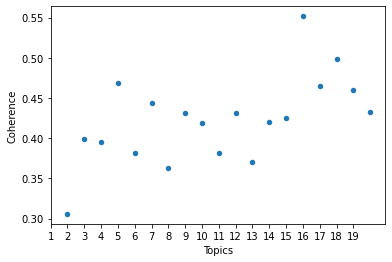

In [37]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'scatter', xticks=range(1,20))

<AxesSubplot:xlabel='Topics'>

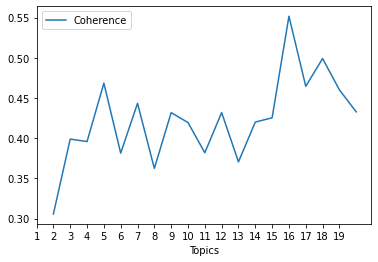

In [38]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'line', xticks=range(1,20))

In [35]:
lda_tuning.to_csv(os.path.join('lda_tuning_results.csv'), index=False)

In [51]:
lda_tuning.to_pickle("./lda_tuning.pkl")

### Tune with changing alpha/beta

In [49]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# alpha = ['symmetric'] # Run for number of topics only

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results_v2 = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results_v2['Topics'].append(k)
                model_results_v2['Alpha'].append(a)
                model_results_v2['Beta'].append(b)
                model_results_v2['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
lda_tuning_v2 = pd.DataFrame(model_results_v2)
lda_tuning_v2.to_csv(os.path.join('lda_tuning_results_v2.csv'), index=False)

LDA will execute 570 iterations
Completed model based on 2 LDA topics. Finished 5.3% of LDA runs
Execution time to calculate for topic 2: 0hour:10min:9sec
Completed model based on 3 LDA topics. Finished 10.5% of LDA runs
Execution time to calculate for topic 3: 0hour:10min:27sec
Completed model based on 4 LDA topics. Finished 15.8% of LDA runs
Execution time to calculate for topic 4: 0hour:10min:27sec
Completed model based on 5 LDA topics. Finished 21.1% of LDA runs
Execution time to calculate for topic 5: 0hour:12min:17sec
Completed model based on 6 LDA topics. Finished 26.3% of LDA runs
Execution time to calculate for topic 6: 0hour:11min:33sec
Completed model based on 7 LDA topics. Finished 31.6% of LDA runs
Execution time to calculate for topic 7: 0hour:10min:45sec
Completed model based on 8 LDA topics. Finished 36.8% of LDA runs
Execution time to calculate for topic 8: 0hour:11min:12sec
Completed model based on 9 LDA topics. Finished 42.1% of LDA runs
Execution time to calculate f

In [52]:
# Best LDA parameters
lda_tuning_v2.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
558,20,0.91,0.91,0.688249
402,15,0.61,0.61,0.581251
427,16,0.31,0.61,0.577487
403,15,0.61,0.91,0.574602
434,16,0.61,symmetric,0.568058
499,18,0.91,symmetric,0.567699
463,17,0.61,0.91,0.566641
444,16,symmetric,symmetric,0.565266
429,16,0.31,symmetric,0.564652
439,16,0.91,symmetric,0.564143


In [50]:
lda_tuning_v2.to_pickle("./lda_tuning_v2.pkl")

## 4. Select N and rerun the model
- Present top N most important topics in these news articles
- Select N to identify relevant topics, but minimize duplication
- Explain how you selected N

### Combination with highest coherence score - Topics: 20, Alpha: 0.91, Beta: 0.91

In [84]:
lda_tuning_best = lda_tuning_v2.sort_values(by=['Coherence'], ascending=False).head(1)
#lda_tuning_best = pd.DataFrame(lda_tuning_v2.sort_values(by=['Coherence'], ascending=False).iloc[4]).T
#lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)
tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))

# Since the values for Alpha and Beta can be float, symmetric and asymmetric, 
# we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 20, Alpha: 0.91, Beta: 0.91


In [85]:
%%time

tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=tuned_topics,
                       random_state=100,
                       passes=10,
                       alpha=tuned_alpha,
                       eta=tuned_beta,
                       workers = workers)

coherence_model_lda = CoherenceModel(model=tuned_lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda.get_coherence())


Coherence Score:  0.6882488885968863
Wall time: 45.8 s


In [86]:
%%time
warnings.filterwarnings("ignore", category=DeprecationWarning) 
lda_display = gensimvis.prepare(tuned_lda_model, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

Wall time: 15.1 s


**This result has very serious duplication problem, so I won't consider this combination. Similar situations happen for the combinations with 2nd-4th highest coherence scores.**

### Final Model with lowest duplication - Topics: 16, Alpha: 0.61, Beta: symmetric (5th highest coherence)

In [79]:
#lda_tuning_best = lda_tuning_v2.sort_values(by=['Coherence'], ascending=False).head(1)
lda_tuning_best = pd.DataFrame(lda_tuning_v2.sort_values(by=['Coherence'], ascending=False).iloc[4]).T
#lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)
tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))

# Since the values for Alpha and Beta can be float, symmetric and asymmetric, 
# we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 16, Alpha: 0.61, Beta: symmetric


In [80]:
%%time

tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=tuned_topics,
                       random_state=100,
                       passes=10,
                       alpha=tuned_alpha,
                       eta=tuned_beta,
                       workers = workers)

coherence_model_lda = CoherenceModel(model=tuned_lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda.get_coherence())


Coherence Score:  0.5680577989833154
Wall time: 24.7 s


In [83]:
# Print the Keyword in the 3 topics
pprint(tuned_lda_model.print_topics())

[(0,
  '0.033*"plant" + 0.016*"wardian_case" + 0.014*"case" + 0.012*"care" + '
  '0.009*"thrive" + 0.008*"day" + 0.007*"bottle" + 0.006*"make" + 0.006*"use" '
  '+ 0.006*"glass_boxe"'),
 (1,
  '0.010*"robot" + 0.007*"market" + 0.006*"include" + 0.006*"grader" + '
  '0.006*"company" + 0.006*"growth" + 0.005*"also" + 0.005*"caterpillar" + '
  '0.005*"work" + 0.005*"expect"'),
 (2,
  '0.012*"city" + 0.010*"town" + 0.009*"live" + 0.008*"university" + '
  '0.005*"list" + 0.005*"scene" + 0.005*"high" + 0.004*"well" + 0.004*"major" '
  '+ 0.004*"median_monthly"'),
 (3,
  '0.011*"forklift" + 0.005*"make" + 0.005*"call" + 0.005*"new" + 0.005*"get" '
  '+ 0.005*"year" + 0.005*"earth" + 0.004*"use" + 0.004*"well" + '
  '0.004*"design"'),
 (4,
  '0.013*"duggan" + 0.007*"facility" + 0.007*"doc_gear" + 0.006*"report" + '
  '0.005*"part" + 0.005*"reconciliation" + 0.005*"completed_duggan" + '
  '0.005*"leds_complete" + 0.005*"receipt" + 0.005*"supplier"'),
 (5,
  '0.014*"amazon_sphere" + 0.013*"marke

In [82]:
%%time
warnings.filterwarnings("ignore", category=DeprecationWarning) 
lda_display = gensimvis.prepare(tuned_lda_model, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

Wall time: 1.15 s


### Explanation:

 - Best Parameters: **Topics: 16, Alpha: 0.61, Beta: symmetric**
 - The reason I choose N=16:
     - The combinations with highest coherence score is N=20, alpha = 0.91, beta = 0.91, with a coherence of 0.688249. However, it has huge duplications among several topics. Similar situations happen for the combinations with 2nd-4th highest coherent score. (by checking the lda display)
     - The current combination: n=16, alpha=0.61 and beta='symmetric' has no duplications according to the above display. It has a 5th highest coherence score of 0.568058, which is good as well and not much lower than the higher ranking coherence. 
     - Also, based on naive tuning loop(no change alpha/beta), the combination with highest coherence is also n=16.
     - Overall N=16 would be a good choice.